# Training with PyTorch

## Dataset and DataLoader

These classes encapsulate process of pulling data from storage and exposing it to training loop in batches.

`Dataset` reponsible for accessing, processing single instances of data.

`DataLoader` pulls data instances from `Dataset`, collects them in batches, returns them for consumption by training loop.

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))]
)

# Create datasets for training/validation, download if needed
training_set = torchvision.datasets.FashionMNIST(
    "./data", train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=transform, download=True
)

# Create dataloaders for datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=4, shuffle=True, num_workers=2
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False, num_workers=2
)

# Class labels
classes = (
    "T-shirt/top",
    "Trousers",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Report split sizes
print(f"Training set has {len(training_set)} instances")
print(f"Validation set has {len(validation_set)} instances")


Training set has 60000 instances
Validation set has 10000 instances


Pullover  Coat  Dress  Ankle Boot


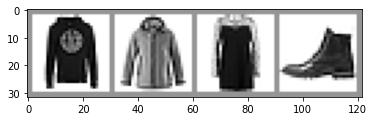

In [6]:
# Visualise data as sanity check

import matplotlib.pyplot as plt
import numpy as np

def mpl_imshow(img, one_channel=False):

    if one_channel:
        img = img.mean(dim=0)  # un-normalise

    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
imgs, labels = dataiter.next()

# Create grid from imgs and show them
img_grid = torchvision.utils.make_grid(imgs)
mpl_imshow(img_grid, one_channel=True)
print("  ".join(classes[labels[j]] for j in range(4)))

## The Model

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

## Loss Function

Using cross-entropy loss. For demo, will create batches of dummy output and label values, run them through loss func, examine result.

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

# Loss functions expect data in batches so creating batches of 4

dummy_outputs = torch.rand(4, 10)  # represents model's confidence in each class for given input
dummy_labels = torch.tensor([1, 5, 3, 7])  # represents correct class among 10 being tested

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print("Total loss for this batch:", loss.item())

tensor([[0.3639, 0.4708, 0.3776, 0.6884, 0.2954, 0.3686, 0.2620, 0.3395, 0.2082,
         0.7485],
        [0.9797, 0.8074, 0.2005, 0.3171, 0.7427, 0.5529, 0.7571, 0.9732, 0.0350,
         0.8106],
        [0.1597, 0.0948, 0.6921, 0.9466, 0.2656, 0.9071, 0.9653, 0.0244, 0.0327,
         0.7801],
        [0.7824, 0.1261, 0.9115, 0.2115, 0.0450, 0.2777, 0.4596, 0.4586, 0.3971,
         0.2277]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.21431303024292


## Optimiser

Can be instructive to try some variations:
* Learning rate
* Momentum
* Different optimation algorithms, e.g. averaged SGD, Adagrad, Adam

In [16]:
# Optimisers specified in the torch.optim package

optimisers = [
    torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
    torch.optim.SGD(model.parameters(), lr=0.001),
    torch.optim.Adam(model.parameters(), lr=0.001)
]

## The Training Loop

Below function performs one training epoch, enumerating data from DataLoader, and on each iteration:
* Gets batch of training data from DataLoader
* Zeroes optimiser gradients
* Performs inference; gets predictions from model for input batch
* Calculates loss and backward gradients over learning weights
* Tells optimiser to perform one learning step; adjust weights based on observed gradients for this batch based on chosen algorithm
* Reports on loss every 1000 batches
* Reports average per-batch loss for last 1000 batches for comparison with validation run

In [17]:
def train_one_epoch(epoch_index, tb_writer, optimiser):
    running_loss = 0.
    last_loss = 0.

    # Here enumerate() instead of iter() so can track batch index and do intra-batch reporting
    for i, data in enumerate(training_loader):
        # Every datum is input & label pair
        inputs, labels = data

        # Zero gradients every batch!
        optimiser.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute loss and gradients wrt weights
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust weights
        optimiser.step()

        # Gather data and report
        running_loss += loss.item()

        if i % 1000 == 999:
            last_loss = running_loss / 1000  # averaged loss per batch over megabatch
            print(f"Batch {i+1} loss: {last_loss}")
            tb_x = epoch_index * len(training_loader) + i+1
            tb_writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Per-Epoch Activity

Things to do once per epoch:
* Perform validation by checking and reporting relative loss on validation set
* Save copy of model

In [22]:
# MAKE SURE TO START TENSORBOARD

def training_run(optimiser):
    """Generic training run function, customisable for different optimisers"""

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(f"runs/fashion_trainer_{timestamp}")

    epoch_number = 0

    EPOCHS = 5

    best_vloss = 1_000_000

    for _ in range(EPOCHS):
        print(f"EPOCH {epoch_number+1}:")

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer, optimiser)

        # Don't need gradients on for reporting
        model.train(False)

        running_vloss = 0.0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print(f"LOSS train {avg_loss} valid {avg_vloss}")

        # Log running loss averaged per batch for both training and validation
        writer.add_scalars(
            "Training vs. Validation Loss",
            {"Training": avg_loss, "Validation": avg_vloss},
            epoch_number + 1,
        )

        writer.flush()

        # Track best performance, and save model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = f"model_{timestamp}_{epoch_number}"
            torch.save(model.state_dict(), model_path)

        epoch_number += 1


Make sure to start TensorBoard before running the below cells.

In [19]:
# SGD, lr=0.001, momentum=0.9

training_run(0)

EPOCH 1:
Batch 1000 loss: 1.7126290408521891
Batch 2000 loss: 0.8384624086413532
Batch 3000 loss: 0.6966749602332711
Batch 4000 loss: 0.6537402897924185
Batch 5000 loss: 0.5720611733436818
Batch 6000 loss: 0.5751306228127796
Batch 7000 loss: 0.5246028355206362
Batch 8000 loss: 0.4736353321049828
Batch 9000 loss: 0.4956321609230945
Batch 10000 loss: 0.46440795248223005
Batch 11000 loss: 0.4758145148215117
Batch 12000 loss: 0.4270937421831768
Batch 13000 loss: 0.437838045676006
Batch 14000 loss: 0.42661332812940234
Batch 15000 loss: 0.4298055310418713
LOSS train 0.4298055310418713 valid 0.4347895383834839
EPOCH 2:
Batch 1000 loss: 0.41278741205175173
Batch 2000 loss: 0.40754263584245926
Batch 3000 loss: 0.4000238726655371
Batch 4000 loss: 0.3842398264088552
Batch 5000 loss: 0.4030686193634756
Batch 6000 loss: 0.40193341950839384
Batch 7000 loss: 0.3752506954791606
Batch 8000 loss: 0.37198587722639787
Batch 9000 loss: 0.3840789081439725
Batch 10000 loss: 0.3656289618322771
Batch 11000 los

In [20]:
# SGD, lr=0.001

training_run(1)

EPOCH 1:
Batch 1000 loss: 0.24618977832436212
Batch 2000 loss: 0.24635323957713626
Batch 3000 loss: 0.24126895120556766
Batch 4000 loss: 0.22853877147223647
Batch 5000 loss: 0.23426763221481905
Batch 6000 loss: 0.22357218346502486
Batch 7000 loss: 0.2177504513482836
Batch 8000 loss: 0.22260619249589944
Batch 9000 loss: 0.2353517508690685
Batch 10000 loss: 0.228757331014368
Batch 11000 loss: 0.22304923653523384
Batch 12000 loss: 0.23947132629652515
Batch 13000 loss: 0.23309855894567955
Batch 14000 loss: 0.21583951324552755
Batch 15000 loss: 0.21360443453460629
LOSS train 0.21360443453460629 valid 0.2815902829170227
EPOCH 2:
Batch 1000 loss: 0.23149234276634342
Batch 2000 loss: 0.214807808103209
Batch 3000 loss: 0.21882522577374766
Batch 4000 loss: 0.22873328799260617
Batch 5000 loss: 0.21863194749140008
Batch 6000 loss: 0.22631141654572365
Batch 7000 loss: 0.2157214766357838
Batch 8000 loss: 0.22720506284161002
Batch 9000 loss: 0.225702301284794
Batch 10000 loss: 0.199851768747576
Batch

In [24]:
# ADAM, lr=0.001

training_run(2)

EPOCH 1:
Batch 1000 loss: 0.2712310774003443
Batch 2000 loss: 0.2512592614982044
Batch 3000 loss: 0.27589194529252925
Batch 4000 loss: 0.2741987713609578
Batch 5000 loss: 0.2481133478852377
Batch 6000 loss: 0.2684995219304658
Batch 7000 loss: 0.25956696652054495
Batch 8000 loss: 0.28887291490546135
Batch 9000 loss: 0.28071789094055954
Batch 10000 loss: 0.2764978868882813
Batch 11000 loss: 0.2720560966147499
Batch 12000 loss: 0.2583016577638297
Batch 13000 loss: 0.2853357129418773
Batch 14000 loss: 0.2741238160131288
Batch 15000 loss: 0.2580068697371863
LOSS train 0.2580068697371863 valid 0.33179861307144165
EPOCH 2:
Batch 1000 loss: 0.25417378903164495
Batch 2000 loss: 0.2587864485671049
Batch 3000 loss: 0.25365071347639084
Batch 4000 loss: 0.24930296084513956
Batch 5000 loss: 0.2436196566917969
Batch 6000 loss: 0.28109803779153614
Batch 7000 loss: 0.23840625013890432
Batch 8000 loss: 0.2484967980351261
Batch 9000 loss: 0.24988567761895006
Batch 10000 loss: 0.2645684273024212
Batch 110

KeyboardInterrupt: 

### Loading Saved Model Versions

In [ ]:
# PATH = ""

# saved_model = GarmentClassifier()
# saved_model.load_state_dict(torch.load(PATH))